In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

## Simulation setup

#### Simulation setup

In [2]:
sim = rw.Simulation()

start simulation


#### Source 

In [6]:
nr_particles = 1*10**2
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
delta_rho_div_phi = 1 #1/2**0.5 # (delta_r_rho / delta_r_phi)
energy = 3*10**15 # eV
phi = 0.0
pitch_angle = 2*np.pi * 54.74/360 # pitch angle for equal components in all directions
        

source = rw.PointSourceOriented(energy, source_pos, nr_particles, pitch_angle, phi)
sim.add_source(source)
sim.source.get_description()

Description Source:
                The source defines the start conditions of the particles 
                and covers the position, direction, energy, etc

position:  [0. 0. 0.]
number particles:  100
energy:  3000000000000000  eV
source tpye: PointSourceOriented
pitch angle:  0.955393232541696
phi:  0.0


#### Propagator

In [7]:
nr_steps = 1*10**4
step_size = 0.5*10**10 # [m]
mfp = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12], dtype=np.float32)  # [m]
rms = 1 # Gaus
magnetic_field = rw.OrderedBackgroundField(rms, [0,0,1]).magnetic_field

propagator = rw.AnisotropicPropagator(magnetic_field, mfp, nr_steps, step_size)
#propagator.set_pitch_angle_const(False)
sim.add_propagator(propagator)
sim.propagator.get_description()

Propagator initialized
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

propagation tpye: AnisotropicPropagator
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

coordinates: Cylindrical coordinates
dimensions:  3
pitch angle: constant
particle sp

#### Observer

In [8]:
substeps = [False, False, True] # observe only steps (no substeps)
min_step = 1
max_step = nr_steps
nr_obs_steps = 200

observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
sim.add_observer(observer)
sim.observer.get_description()

number steps:  154
Observer initialized
Description Observer:
                The observer defines the conditions for when to write data to the output.

observer tpye: TimeEvolutionObserverLog
spheres:  [-1.]
steps [0:10]:  [ 1  2  3  4  5  6  7  8  9 10]
steps [-11:-1]:  [6294 6593 6905 7232 7575 7934 8309 8703 9115 9547]
nr steps:  154
substeps:  [False False  True]
all_steps:  False


In [9]:
%time sim.run_simulation()
sim.save_data('data/data_sim')

CPU times: user 5.86 s, sys: 12 ms, total: 5.88 s
Wall time: 5.87 s


## Analyze statistics


init statistics plotting class


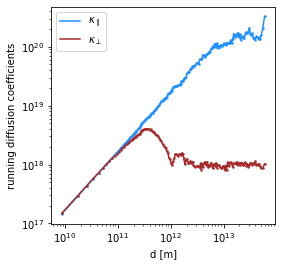

In [10]:
df = pd.read_pickle("data/data_sim.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
sta = rw.Statistics(df_time_evolution_observer)
errors = False
df_kappas = sta.plot_diffusion_coefficients(errors)

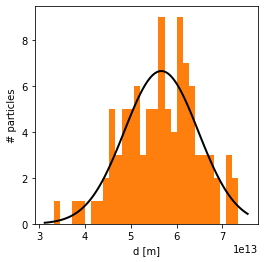

In [11]:
bins = 30
file_name = None
df_kappas = sta.plot_distribution('d', -1, bins, file_name)

In [12]:
df

,id,i,d,x,y,z,phi,pitch_angle,radius,sub_step
0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.955393,-1.0,0.0
1,0.0,1.0,8.660254e+09,2.811186e+09,3.030200e+09,2.886438e+09,0.049968,0.955393,-1.0,2.0
2,0.0,2.0,1.732051e+10,5.467512e+09,6.197028e+09,5.772877e+09,0.099936,0.955393,-1.0,2.0
3,0.0,3.0,2.598076e+10,7.962350e+09,9.492579e+09,8.659315e+09,0.149904,0.955393,-1.0,2.0
4,0.0,4.0,3.464101e+10,1.028947e+10,1.290863e+10,1.154575e+10,0.199872,0.955393,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
15395,99.0,7934.0,4.740476e+13,8.321845e+11,5.122812e+11,1.599097e+12,-100.533981,0.955393,-1.0,2.0
15396,99.0,8309.0,4.917946e+13,8.447990e+11,3.426581e+11,1.209424e+12,-111.076576,0.955393,-1.0,2.0
15397,99.0,8703.0,5.259033e+13,9.249242e+11,3.316031e+11,2.346692e+12,-130.763168,0.955393,-1.0,2.0
15398,99.0,9115.0,5.615703e+13,9.952019e+11,6.268633e+10,3.535916e+12,-151.351852,0.955393,-1.0,2.0


(array([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

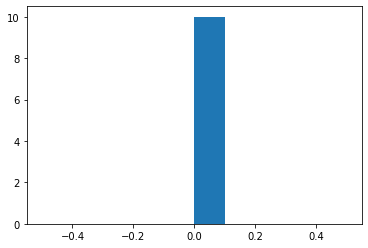

In [10]:
plt.hist(df['d'])

init trajectory plotting class


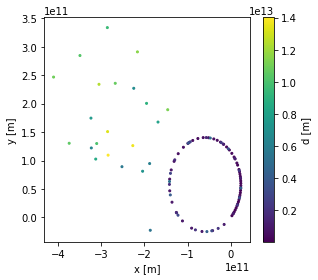

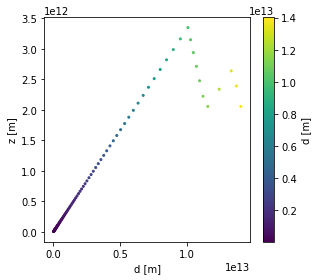

In [11]:
tra = rw.Trajectory(df_time_evolution_observer)
particle_ids = tra.get_particle_ids()
nr_steps = 100
tra.plot_trajectory('x', 'y', 'd', particle_ids[0], nr_steps, None)
tra.plot_trajectory('d', 'z', 'd', particle_ids[0], nr_steps, None)